In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
b4_path = "./imagenes/bandas/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B04_(Raw).tiff"  # Banda roja
b8_path = "./imagenes/bandas/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B8A_(Raw).tiff"  # Banda NIR
out_path = "./imagenes/bandas/NDVI_olaroz_corrected.tif"  # Salida NDVI corregido

In [3]:
with rasterio.open(b4_path) as red_src, rasterio.open(b8_path) as nir_src:
    red = red_src.read(1).astype("float32")
    nir = nir_src.read(1).astype("float32")
    profile = red_src.profile

In [4]:
red /= 10000
nir /= 10000

In [5]:
np.seterr(divide='ignore', invalid='ignore')
ndvi = (nir - red) / (nir + red)
ndvi[(nir + red) == 0] = np.nan

In [6]:
print("Rango NDVI corregido:", np.nanmin(ndvi), np.nanmax(ndvi))

Rango NDVI corregido: -1.0 1.0


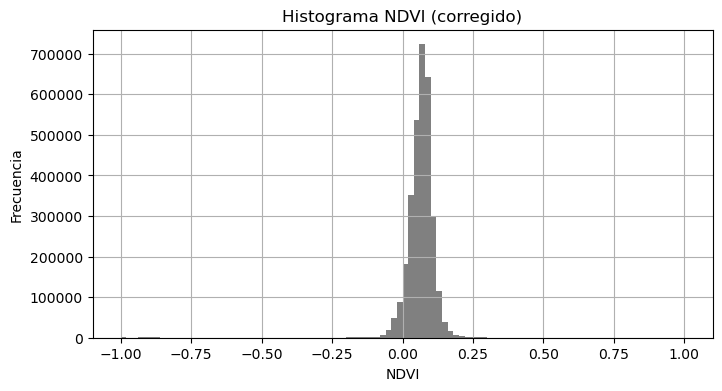

In [7]:
plt.figure(figsize=(8,4))
plt.hist(ndvi[np.isfinite(ndvi)], bins=100, color="gray")
plt.title("Histograma NDVI (corregido)")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

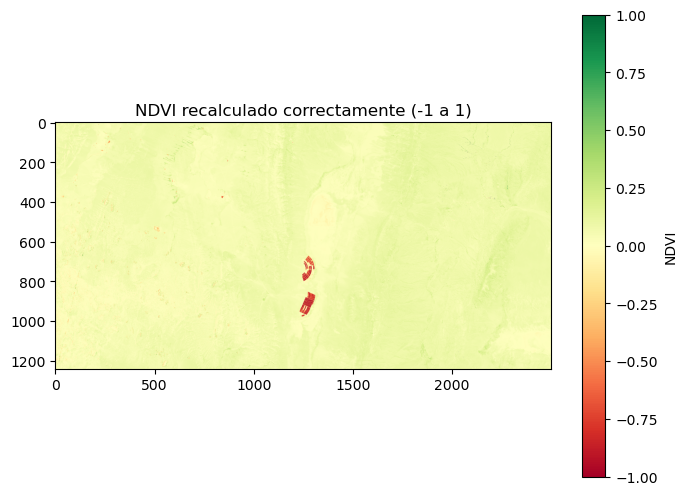

In [8]:
plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title("NDVI recalculado correctamente (-1 a 1)")
plt.show()

In [9]:
profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)
with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(ndvi.astype(rasterio.float32), 1)

print(f"✅ NDVI guardado como: {out_path}")

✅ NDVI guardado como: ./imagenes/bandas/NDVI_olaroz_corrected.tif


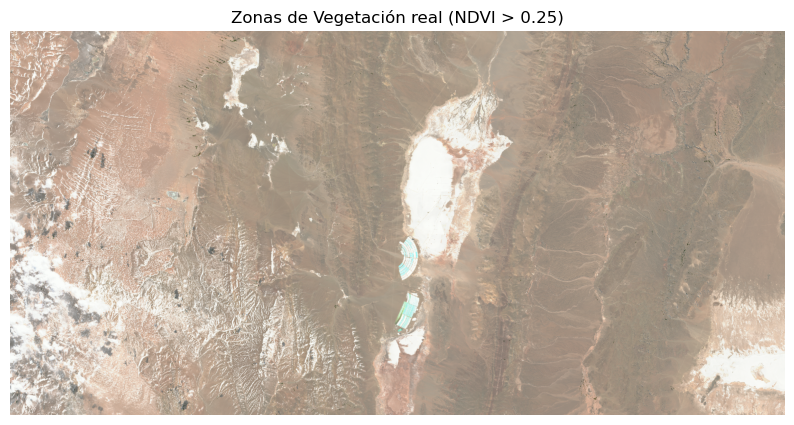

✅ Mapa guardado como: ./imagenes/bandas/truecolor_vegetacion.png
📁 Polígonos exportados a: ./imagenes/bandas/vegetacion_olaroz.geojson


In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import shape
import rasterio.features


true_color_path = "./imagenes/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_True_color.tiff"
ndvi_path = "./imagenes/bandas/NDVI_olaroz_corrected.tif"
out_png = "./imagenes/bandas/truecolor_vegetacion.png"
out_geojson = "./imagenes/bandas/vegetacion_olaroz.geojson"


with rasterio.open(ndvi_path) as ndvi_src:
    ndvi = ndvi_src.read(1)
    ndvi_profile = ndvi_src.profile


with rasterio.open(true_color_path) as rgb_src:
    rgb = rgb_src.read([1, 2, 3]).astype("float32")
    rgb = np.clip(rgb / np.nanmax(rgb), 0, 1)  # normalizar a 0–1


veg_mask = np.where(ndvi > 0.25, 1, 0).astype("uint8")

plt.figure(figsize=(10,10))
plt.imshow(np.moveaxis(rgb, 0, -1))
plt.imshow(veg_mask, cmap="Greens", alpha=0.4)
plt.title("Zonas de Vegetación real (NDVI > 0.25)")
plt.axis("off")
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Mapa guardado como: {out_png}")

shapes = rasterio.features.shapes(veg_mask, mask=veg_mask==1, transform=ndvi_profile["transform"])
geoms = [{"geometry": shape(geom), "properties": {"class_name": "vegetacion"}} for geom, val in shapes if val == 1]
gdf = gpd.GeoDataFrame.from_features(geoms, crs=ndvi_profile["crs"])
gdf.to_file(out_geojson, driver="GeoJSON")
print(f"📁 Polígonos exportados a: {out_geojson}")


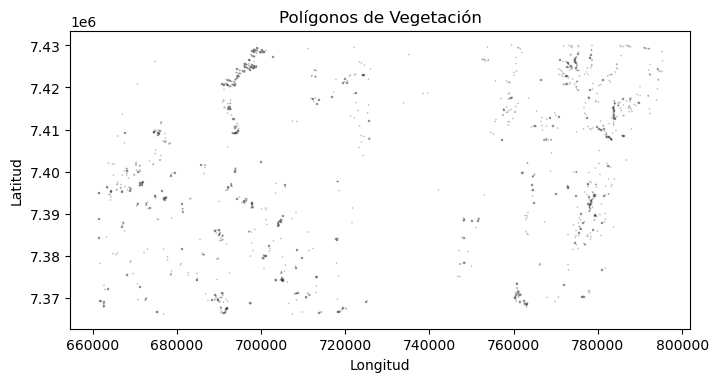

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("./imagenes/bandas/vegetacion_olaroz.geojson")

gdf.plot(edgecolor='black', facecolor='green', alpha=0.4, figsize=(8,8))
plt.title("Polígonos de Vegetación")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

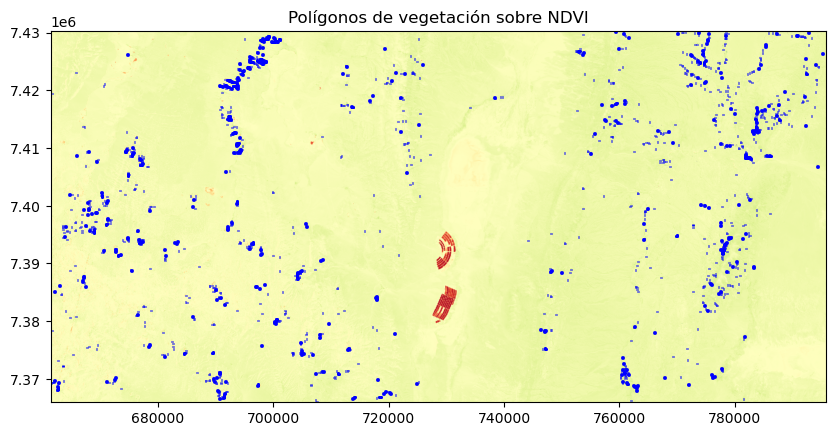

In [12]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt

# Leer NDVI y GeoJSON
ndvi_path = "./imagenes/bandas/NDVI_olaroz_corrected.tif"
gdf = gpd.read_file("./imagenes/bandas/vegetacion_olaroz.geojson")

with rasterio.open(ndvi_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='RdYlGn', vmin=-1, vmax=1)
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
    plt.title("Polígonos de vegetación sobre NDVI")
plt.show()

In [13]:
print("Cantidad de polígonos:", len(gdf))

Cantidad de polígonos: 2409


In [14]:
sub_gdf = gdf.sample(frac=0.3, random_state=42)
sub_gdf.to_file("./imagenes/bandas/svegetacion.geojson", driver="GeoJSON")
print("Cantidad total:", len(gdf))
print("Submuestra (30 %):", len(sub_gdf))

Cantidad total: 2409
Submuestra (30 %): 723


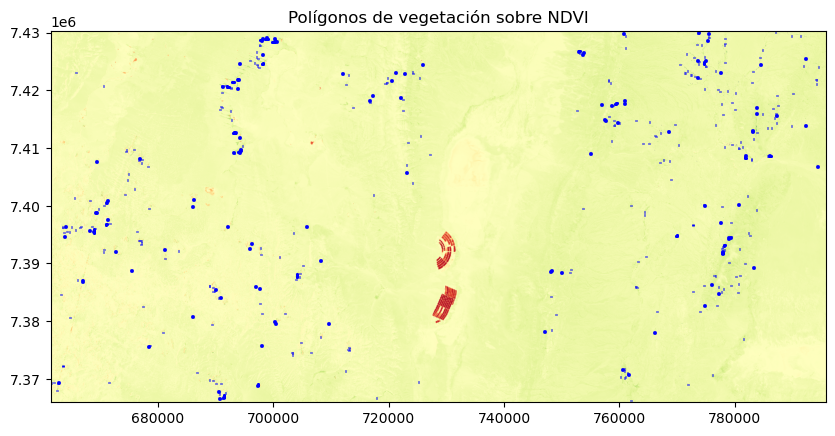

In [15]:
# Leer NDVI y GeoJSON
ndvi_path = "./imagenes/bandas/NDVI_olaroz_corrected.tif"
gdf = gpd.read_file("./imagenes/bandas/svegetacion.geojson")

with rasterio.open(ndvi_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='RdYlGn', vmin=-1, vmax=1)
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
    plt.title("Polígonos de vegetación sobre NDVI")
plt.show()

In [16]:
import json
import geopandas as gpd
import pandas as pd

from shapely.geometry import shape, Polygon, MultiPolygon
from pyproj import CRS

path1 = "./imagenes/bandas/clases_ia.geojson"
path2 = "./imagenes/bandas/svegetacion.geojson"
target_crs = "EPSG:32719"  # UTM 19S (como pediste)

out_geojson = "./imagenes/bandas/ia2_clases.geojson"
out_gpkg    = "./imagenes/bandas/ia2_clases.gpkg"  # recomendado para CRS ≠ 4326
layer_name  = "classes_ia"

def parse_crs_from_geojson_dict(d):
    """
    Devuelve un string EPSG si el GeoJSON trae 'crs' (no estándar RFC 7946 pero común).
    Si no, retorna None.
    """
    crs_info = d.get("crs")
    if not crs_info:
        return None
    name = crs_info.get("properties", {}).get("name")
    if not name:
        return None
    try:
        crs = CRS.from_user_input(name)
        return crs.to_string()  # e.g. 'EPSG:32719'
    except Exception:
        return None

def safe_read_geojson(path, default_crs=None):
    """
    Lee GeoJSON sin tropezar con MultiPolygon y asigna CRS:
    - Si el archivo trae 'crs', lo usa.
    - Si no trae y default_crs está dado, lo usa.
    """
    with open(path, "r", encoding="utf-8") as f:
        d = json.load(f)

    detected = parse_crs_from_geojson_dict(d) or default_crs
    rows = []
    for feat in d["features"]:
        geom = shape(feat["geometry"]) if feat.get("geometry") else None
        props = feat.get("properties", {}).copy()
        rows.append({**props, "geometry": geom})

    gdf = gpd.GeoDataFrame(rows, geometry="geometry", crs=detected)
    return gdf


def to_multipolygon(geom):
    if geom is None:
        return None
    if isinstance(geom, Polygon):
        return MultiPolygon([geom])
    return geom

In [17]:
gdf1 = safe_read_geojson(path1, default_crs=target_crs)
gdf2 = safe_read_geojson(path2, default_crs=target_crs)

In [18]:
if gdf1.crs is None:
    gdf1.set_crs(target_crs, inplace=True)
if gdf2.crs is None:
    gdf2.set_crs(target_crs, inplace=True)

if gdf1.crs.to_string() != target_crs:
    gdf1 = gdf1.to_crs(target_crs)
if gdf2.crs.to_string() != target_crs:
    gdf2 = gdf2.to_crs(target_crs)

# Unificar geometría como MultiPolygon
gdf1["geometry"] = gdf1["geometry"].apply(to_multipolygon)
gdf2["geometry"] = gdf2["geometry"].apply(to_multipolygon)

In [19]:
all_cols = sorted(set(gdf1.columns) | set(gdf2.columns))
gdf1 = gdf1.reindex(columns=all_cols)
gdf2 = gdf2.reindex(columns=all_cols)

In [20]:
union = gpd.GeoDataFrame(
    pd.concat([gdf1, gdf2], ignore_index=True),
    geometry="geometry",
    crs=target_crs
)

In [21]:
print("CRS final:", union.crs)
print("Geom types:", union.geom_type.value_counts().to_dict())
print("Polígonos totales:", len(union))
print("Columnas:", union.columns.tolist())

# ======== Exportar ========
# 1) GeoPackage (recomendado, preserva CRS ≠ 4326 sin problemas)
union.to_file(out_gpkg, layer=layer_name, driver="GPKG")
print(f"✅ Guardado GPKG: {out_gpkg} (capa: {layer_name})")

# 2) GeoJSON (advertencia: RFC 7946 recomienda 4326; igual muchos GIS leen CRS incrustado)
union.to_file(out_geojson, driver="GeoJSON")
print(f"✅ Guardado GeoJSON: {out_geojson}")

CRS final: EPSG:32719
Geom types: {'MultiPolygon': 732}
Polígonos totales: 732
Columnas: ['class_name', 'geometry', 'id']
✅ Guardado GPKG: ./imagenes/bandas/ia2_clases.gpkg (capa: classes_ia)
✅ Guardado GeoJSON: ./imagenes/bandas/ia2_clases.geojson


In [22]:
union

,class_name,geometry,id
0,agua_humedad,"MULTIPOLYGON (((729717.217 7384544.338, 729834...",1.0
1,agua_humedad,"MULTIPOLYGON (((729271.372 7391806.925, 728989...",1.0
2,salina,"MULTIPOLYGON (((729693.752 7403410.638, 730585...",2.0
3,salina,"MULTIPOLYGON (((731635.526 7379780.832, 732433...",2.0
4,salina,"MULTIPOLYGON (((727036.279 7375791.689, 727083...",2.0
...,...,...,...
727,vegetacion,"MULTIPOLYGON (((677046.237 7393694.182, 677046...",NaN
728,vegetacion,"MULTIPOLYGON (((780127.194 7405217.242, 780127...",NaN
729,vegetacion,"MULTIPOLYGON (((693868.103 7421982.777, 693868...",NaN
730,vegetacion,"MULTIPOLYGON (((780610.889 7400234.297, 780610...",NaN


In [23]:
union["id"] = union["id"].fillna(4)

In [24]:
union

,class_name,geometry,id
0,agua_humedad,"MULTIPOLYGON (((729717.217 7384544.338, 729834...",1.0
1,agua_humedad,"MULTIPOLYGON (((729271.372 7391806.925, 728989...",1.0
2,salina,"MULTIPOLYGON (((729693.752 7403410.638, 730585...",2.0
3,salina,"MULTIPOLYGON (((731635.526 7379780.832, 732433...",2.0
4,salina,"MULTIPOLYGON (((727036.279 7375791.689, 727083...",2.0
...,...,...,...
727,vegetacion,"MULTIPOLYGON (((677046.237 7393694.182, 677046...",4.0
728,vegetacion,"MULTIPOLYGON (((780127.194 7405217.242, 780127...",4.0
729,vegetacion,"MULTIPOLYGON (((693868.103 7421982.777, 693868...",4.0
730,vegetacion,"MULTIPOLYGON (((780610.889 7400234.297, 780610...",4.0


In [25]:
# 1) GeoPackage (recomendado, preserva CRS ≠ 4326 sin problemas)
union.to_file("./imagenes/bandas/iavf_clases.gpkg", layer=layer_name, driver="GPKG")
print(f"✅ Guardado GPKG: {out_gpkg} (capa: {layer_name})")

# 2) GeoJSON (advertencia: RFC 7946 recomienda 4326; igual muchos GIS leen CRS incrustado)
union.to_file("./imagenes/bandas/iavf_clases.geojson", driver="GeoJSON")
print(f"✅ Guardado GeoJSON: {out_geojson}")

✅ Guardado GPKG: ./imagenes/bandas/ia2_clases.gpkg (capa: classes_ia)
✅ Guardado GeoJSON: ./imagenes/bandas/ia2_clases.geojson
